In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import os
import random
from sam.sam import SAM
from sam.example.utility.bypass_bn import enable_running_stats, disable_running_stats
from collections import defaultdict

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Make CUDA ops deterministic where possible
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generator seeded for deterministic splits
_gen = torch.Generator()
_gen.manual_seed(SEED)

# Ensure random_split uses the seeded generator by default
_orig_random_split = random_split
def random_split(dataset, lengths, generator=None):
    return _orig_random_split(dataset, lengths, generator=generator if generator is not None else _gen)

Evaluation Metrics: For each experiment, evaluate model performance on:
- **Target (unseen) domain accuracy:** the primary metric for domain adaptation/generalization success.
- **Source domain accuracy:** to observe if source performance drops when adapting/generalizing.
- **Domain-wise accuracy:** accuracy on each domain separately (when applicable) to see how performance
varies.
- **Worst-group accuracy:** in multi-domain scenarios, the accuracy on the worst performing domain (reflects
robustness to the most difficult domain shift).
- **Average accuracy across domains:** when relevant

# Loading Dataset (PACS)

In [3]:
MODEL_DIR = '/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models'

In [4]:
DIR_PHOTO = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [5]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name],
                                domain
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, domain = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, domain

In [6]:
TRAIN_DOMAINS = ['photo', 'art_painting', 'cartoon']
TEST_DOMAINS = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TRAIN_DOMAINS,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TEST_DOMAINS,
    transform=transform
)

In [7]:
train_size = int(0.95 * len(pacs_train))
val_size = len(pacs_train) - train_size
pacs_train_split, pacs_val_split = random_split(pacs_train, [train_size, val_size])

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ALTERNATIVELY DO NOT CREATE A VALIDATION SPLIT
pacs_train_loader = DataLoader(pacs_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_val_loader = DataLoader(pacs_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Validating on {len(pacs_val_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(TEST_DOMAINS)}")

Training on 5758 images from domains: photo, art_painting, cartoon
Validating on 304 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [8]:
pacs_source_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

pacs_photo = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['photo'],transform=transform)
pacs_photo_loader = DataLoader(pacs_photo, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_art_painting = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['art_painting'],transform=transform)
pacs_art_painting_loader = DataLoader(pacs_art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_cartoon = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['cartoon'],transform=transform)
pacs_cartoon_loader = DataLoader(pacs_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 1) ERM Baseline

In [9]:
erm_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
erm_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
def train_model(model, dataloader, criterion, optimizer, epochs):
    max_validation_accuracy = 0.0
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels, _ in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(dataloader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)
        
        print(f"Epoch {epoch+1}")
        print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # ALTERNATIVELY DO NOT VALIDATE
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in pacs_val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        if val_acc >= max_validation_accuracy:
            max_validation_accuracy = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_erm_resnet.pth'))
        avg_val_loss = val_running_loss / len(pacs_val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        
        print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [11]:
erm_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
erm_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(erm_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in erm_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

# for m in erm_resnet_pacs.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.eval()
                
erm_resnet_pacs = erm_resnet_pacs.to(DEVICE)
erm_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
erm_resnet_pacs_optimizer = optim.Adam(erm_resnet_pacs.parameters(), lr=0.001)

In [12]:
# ALTERNATIVE APPROACH:
# resnet_pacs.fc = torch.nn.Linear(resnet_pacs.fc.in_features, len(pacs_train.classes))

# # Freeze backbone, only train the last layer
# for param in resnet_pacs.parameters():
#     param.requires_grad = False
# for param in resnet_pacs.fc.parameters():
#     param.requires_grad = True
# resnet_pacs_optimizer = optim.Adam(resnet_pacs.fc.parameters(), lr=0.005)

In [13]:
print("Fine-tuning ResNet-50 on PACS dataset...")
resnet_pacs_train_acc, resnet_pacs_train_loss, resnet_pacs_val_acc, resnet_pacs_val_loss = train_model(
    model=erm_resnet_pacs,
    dataloader=pacs_train_loader,
    criterion=erm_resnet_pacs_criterion,
    optimizer=erm_resnet_pacs_optimizer,
    epochs=50
)
torch.save(erm_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'erm_resnet.pth'))

Fine-tuning ResNet-50 on PACS dataset...


Epoch 1
	Training Loss: 0.6916, Train Acc: 77.77%
	Validation Loss: 0.4359, Validation Acc: 85.53%
Epoch 2
	Training Loss: 0.3405, Train Acc: 88.89%
	Validation Loss: 0.3334, Validation Acc: 90.46%
Epoch 3
	Training Loss: 0.2232, Train Acc: 92.71%
	Validation Loss: 0.5244, Validation Acc: 85.20%
Epoch 4
	Training Loss: 0.1865, Train Acc: 94.10%
	Validation Loss: 0.5289, Validation Acc: 84.87%
Epoch 5
	Training Loss: 0.1453, Train Acc: 95.33%
	Validation Loss: 0.6429, Validation Acc: 83.55%
Epoch 6
	Training Loss: 0.1508, Train Acc: 95.28%
	Validation Loss: 0.3652, Validation Acc: 89.47%
Epoch 7
	Training Loss: 0.0990, Train Acc: 96.89%
	Validation Loss: 0.3587, Validation Acc: 89.14%
Epoch 8
	Training Loss: 0.0678, Train Acc: 97.99%
	Validation Loss: 0.3441, Validation Acc: 89.80%
Epoch 9
	Training Loss: 0.0797, Train Acc: 97.43%
	Validation Loss: 0.2969, Validation Acc: 92.11%
Epoch 10
	Training Loss: 0.0845, Train Acc: 97.36%
	Validation Loss: 0.1922, Validation Acc: 92.76%
Epoch 11


In [14]:
def compute_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

## Evaluate ERM Model - Best Checkpoint 

In [15]:
erm_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_erm_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Best)

In [16]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 66.76%


### Source Domain Evaluation (Best)

In [17]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
worst_group_acc_erm = min(domain_accuracies)
avg_source_acc_erm = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.60%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.64%
ResNet-50 Accuracy on PACS Art Domain: 99.41%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.74%

Worst-group accuracy (source domains): 99.41%
Average accuracy (source domains): 99.60%


## Evaluate ERM Model - Last Checkpoint 

In [18]:
erm_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'erm_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Last)

In [19]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 65.05%


### Source Domain Evaluation (Last)

In [20]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
worst_group_acc_erm = min(domain_accuracies)
avg_source_acc_erm = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.52%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.70%
ResNet-50 Accuracy on PACS Art Domain: 99.32%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.32%
Average accuracy (source domains): 99.53%


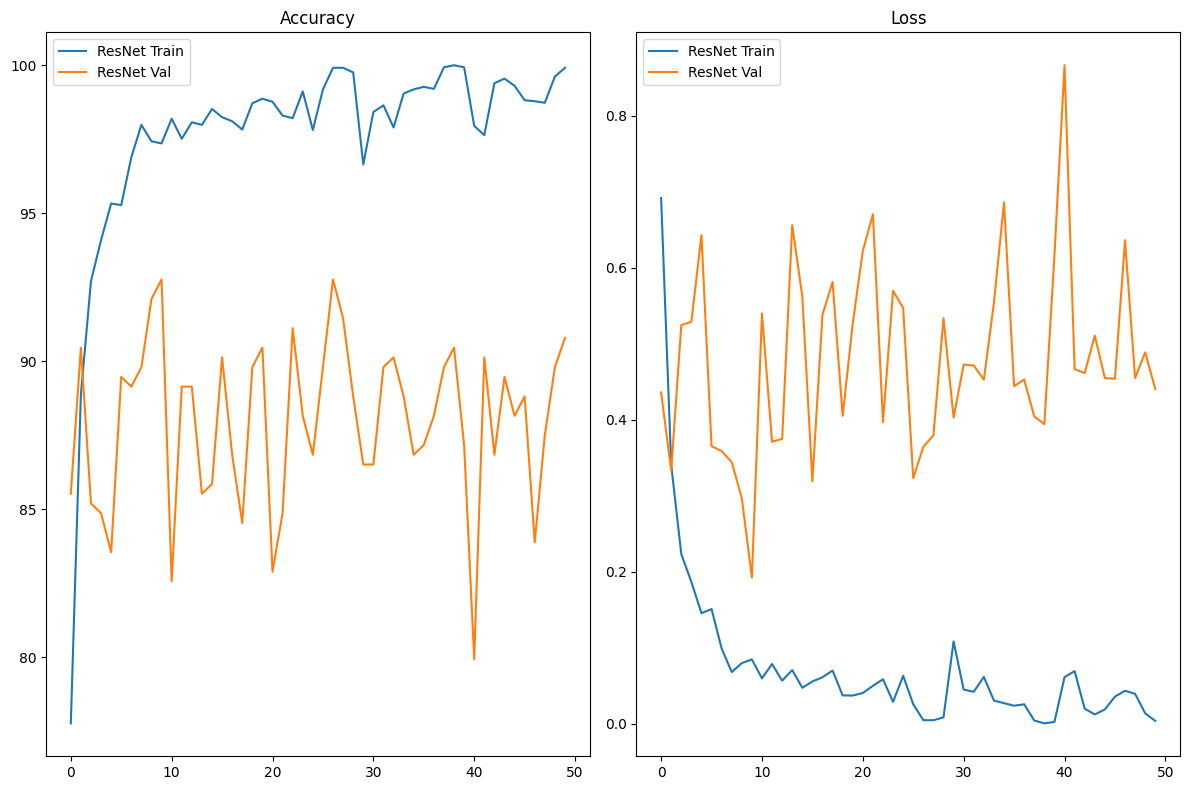

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(resnet_pacs_train_acc, label='ResNet Train')
plt.plot(resnet_pacs_val_acc, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(resnet_pacs_train_loss, label='ResNet Train')
plt.plot(resnet_pacs_val_loss, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 2) IRM

In [22]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()

#     def forward(self, x):
#         return x


# class ResNet(torch.nn.Module):
#     def __init__(self, input_shape, hparams):
#         super(ResNet, self).__init__()
   
#         self.network = torchvision.models.resnet50(pretrained=True)
#         self.n_outputs = 2048

#         nc = input_shape[0]
#         if nc != 3:
#             raise ValueError("Input shape must have 3 channels (RGB images).")

#         del self.network.fc
#         self.network.fc = Identity()

#         self.freeze_bn()
#         self.hparams = hparams
#         self.dropout = nn.Dropout(0.25)
#         self.activation = nn.Identity()

#     def forward(self, x):
#         return self.activation(self.dropout(self.network(x)))

#     def train(self, mode=True):
#         super().train(mode)
#         self.freeze_bn()

#     def freeze_bn(self):
#         for m in self.network.modules():
#             if isinstance(m, nn.BatchNorm2d):
#                 m.eval()

# def Featurizer(input_shape, hparams):
#     return ResNet(input_shape, hparams)

# def Classifier(in_features, out_features):
#     return torch.nn.Linear(in_features, out_features)

In [23]:
class Algorithm(torch.nn.Module):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

class ERM(Algorithm):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        
        # self.featurizer = Featurizer(input_shape, self.hparams)
        # self.classifier = Classifier(
        #     self.featurizer.n_outputs,
        #     num_classes,
        #     self.hparams['nonlinear_classifier'])

        # self.network = nn.Sequential(self.featurizer, self.classifier)
        
        self.network = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        self.network.fc = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(self.network.fc.in_features, num_classes)
        )
        
        for m in self.network.modules():
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                m.eval()
                for param in m.parameters():
                    param.requires_grad = False
            
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=0.001,
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)
        
class IRM(ERM):
    """Invariant Risk Minimization"""

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(IRM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.register_buffer('update_count', torch.tensor([0]))

    @staticmethod
    def _irm_penalty(logits, y):
        device = "cuda" if logits[0][0].is_cuda else "cpu"
        scale = torch.tensor(1.).to(device).requires_grad_()
        loss_1 = F.cross_entropy(logits[::2] * scale, y[::2])
        loss_2 = F.cross_entropy(logits[1::2] * scale, y[1::2])
        grad_1 = autograd.grad(loss_1, [scale], create_graph=True)[0]
        grad_2 = autograd.grad(loss_2, [scale], create_graph=True)[0]
        result = torch.sum(grad_1 * grad_2)
        return result

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"
        penalty_weight = (self.hparams['irm_lambda'] if self.update_count
                          >= self.hparams['irm_penalty_anneal_iters'] else
                          1.0)
        nll = 0.
        penalty = 0.

        all_x = torch.cat([x for x, y in minibatches])
        all_logits = self.network(all_x)
        all_logits_idx = 0
        for i, (x, y) in enumerate(minibatches):
            logits = all_logits[all_logits_idx:all_logits_idx + x.shape[0]]
            all_logits_idx += x.shape[0]
            nll += F.cross_entropy(logits, y)
            penalty += self._irm_penalty(logits, y)
        nll /= len(minibatches)
        penalty /= len(minibatches)
        loss = nll + (penalty_weight * penalty)

        if self.update_count == self.hparams['irm_penalty_anneal_iters']:
            # Reset Adam, because it doesn't like the sharp jump in gradient
            # magnitudes that happens at this step.
            self.optimizer = torch.optim.Adam(
                self.network.parameters(),
                lr=0.001)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_count += 1
        return {'loss': loss.item(), 'nll': nll.item(),
            'penalty': penalty.item()}

In [24]:
input_shape = (3, 224, 224)
num_classes = len(pacs_train.classes)
num_domains = len(TRAIN_DOMAINS)

hparams = {
    'irm_lambda': 1e2,
    'irm_penalty_anneal_iters': 500
}

irm_model = IRM(input_shape, num_classes, num_domains, hparams)
irm_model = irm_model.to(DEVICE)
print(f"IRM Model initialized with {num_domains} domains and {num_classes} classes")

IRM Model initialized with 3 domains and 7 classes


In [25]:
# # First, add the InfiniteDataLoader class
# class _InfiniteSampler(torch.utils.data.Sampler):
#     """Wraps another Sampler to yield an infinite stream."""
#     def __init__(self, sampler):
#         self.sampler = sampler

#     def __iter__(self):
#         while True:
#             for batch in self.sampler:
#                 yield batch

# class InfiniteDataLoader:
#     def __init__(self, dataset, weights, batch_size, num_workers):
#         super().__init__()

#         if weights is not None:
#             sampler = torch.utils.data.WeightedRandomSampler(
#                 weights,
#                 replacement=True,
#                 num_samples=batch_size
#             )
#         else:
#             sampler = torch.utils.data.RandomSampler(
#                 dataset,
#                 replacement=True
#             )

#         batch_sampler = torch.utils.data.BatchSampler(
#             sampler,
#             batch_size=batch_size,
#             drop_last=True
#         )

#         self._infinite_iterator = iter(torch.utils.data.DataLoader(
#             dataset,
#             num_workers=num_workers,
#             batch_sampler=_InfiniteSampler(batch_sampler)
#         ))

#     def __iter__(self):
#         while True:
#             yield next(self._infinite_iterator)

#     def __len__(self):
#         raise ValueError("InfiniteDataLoader has no length")

In [26]:
# # Create domain-specific infinite data loaders for IRM
# from collections import defaultdict

# def group_by_domain(dataset):
#     """Group dataset samples by domain"""
#     domain_indices = defaultdict(list)
#     for idx in range(len(dataset)):
#         _, _, domain = dataset.dataset[dataset.indices[idx]]
#         domain_indices[domain].append(idx)
#     return domain_indices

# # For training set - create infinite loaders
# train_domain_indices = group_by_domain(pacs_train_split)
# train_loaders = []

# for domain in TRAIN_DOMAINS:
#     indices = train_domain_indices[domain]
#     subset = torch.utils.data.Subset(pacs_train_split, indices)
    
#     # No weights (uniform sampling)
#     loader = InfiniteDataLoader(
#         dataset=subset,
#         weights=None,
#         batch_size=BATCH_SIZE,
#         num_workers=2
#     )
#     train_loaders.append(loader)

# print(f"Infinite loaders created for domains: {TRAIN_DOMAINS}")
# for i, domain in enumerate(TRAIN_DOMAINS):
#     indices = train_domain_indices[domain]
#     print(f"  {domain}: {len(indices)} samples")

# # Create the zipped iterator
# train_minibatches_iterator = zip(*train_loaders)

In [27]:
def group_by_domain(dataset):
    """Group dataset samples by domain"""
    domain_indices = defaultdict(list)
    for idx in range(len(dataset)):
        _, _, domain = dataset.dataset[dataset.indices[idx]]
        domain_indices[domain].append(idx)
    return domain_indices

# For training set
train_domain_indices = group_by_domain(pacs_train_split)
train_domain_loaders = {}
for domain in TRAIN_DOMAINS:
    indices = train_domain_indices[domain]
    subset = torch.utils.data.Subset(pacs_train_split, indices)
    train_domain_loaders[domain] = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Domain-specific loaders created:")
for domain, loader in train_domain_loaders.items():
    print(f"  {domain}: {len(loader.dataset)} samples")

# For validation set
val_domain_indices = group_by_domain(pacs_val_split)
val_domain_loaders = {}
for domain in TRAIN_DOMAINS:
    indices = val_domain_indices[domain]
    subset = torch.utils.data.Subset(pacs_val_split, indices)
    val_domain_loaders[domain] = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Domain-specific loaders created:
  photo: 1584 samples
  art_painting: 1947 samples
  cartoon: 2227 samples


In [28]:
# # Training loop for IRM with InfiniteDataLoader
# EPOCHS = 50
# max_validation_accuracy = 0.0
# irm_train_losses = []
# irm_train_nlls = []
# irm_train_penalties = []
# irm_val_accuracies = []
# irm_val_losses = []

# # Calculate steps per epoch and total steps
# steps_per_epoch = min([len(train_domain_indices[domain]) // BATCH_SIZE 
#                        for domain in TRAIN_DOMAINS])
# n_steps = EPOCHS * steps_per_epoch

# print(f"Training IRM model with InfiniteDataLoader...")
# print(f"Steps per epoch: {steps_per_epoch}")
# print(f"Total steps: {n_steps}")

# epoch = 0
# for step in range(n_steps):
#     irm_model.train()
    
#     # Get one minibatch from each domain (via zip)
#     minibatches_device = [(x.to(DEVICE), y.to(DEVICE))
#                           for x, y, _ in next(train_minibatches_iterator)]
    
#     # Update the model
#     step_results = irm_model.update(minibatches_device)
    
#     # Track step-level metrics (optional - for monitoring)
#     if step % 10 == 0:  # Print every 10 steps
#         print(f"Step {step}/{n_steps}: Loss={step_results['loss']:.4f}, "
#               f"NLL={step_results['nll']:.4f}, Penalty={step_results['penalty']:.4f}")
    
#     # Epoch-level evaluation
#     if (step + 1) % steps_per_epoch == 0:
#         epoch += 1
        
#         # Calculate average metrics for the epoch
#         # (You could accumulate step_results throughout the epoch instead)
#         avg_loss = step_results['loss']  # Simplified - last step of epoch
#         avg_nll = step_results['nll']
#         avg_penalty = step_results['penalty']
        
#         irm_train_losses.append(avg_loss)
#         irm_train_nlls.append(avg_nll)
#         irm_train_penalties.append(avg_penalty)
        
#         print(f"\nEpoch {epoch}/{EPOCHS}")
#         print(f"  Train Loss: {avg_loss:.4f}, NLL: {avg_nll:.4f}, Penalty: {avg_penalty:.4f}")
        
#         # Validation
#         irm_model.eval()
#         val_correct = 0
#         val_total = 0
#         val_loss = 0.0
#         val_batches = 0
        
#         with torch.no_grad():
#             for images, labels, _ in pacs_val_loader:
#                 images, labels = images.to(DEVICE), labels.to(DEVICE)
#                 outputs = irm_model.predict(images)
#                 loss = F.cross_entropy(outputs, labels)
#                 val_loss += loss.item()
#                 val_batches += 1
                
#                 _, predicted = outputs.max(1)
#                 val_total += labels.size(0)
#                 val_correct += predicted.eq(labels).sum().item()
        
#         val_acc = 100. * val_correct / val_total
#         avg_val_loss = val_loss / val_batches
        
#         irm_val_accuracies.append(val_acc)
#         irm_val_losses.append(avg_val_loss)
        
#         print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
#         if val_acc >= max_validation_accuracy:
#             max_validation_accuracy = val_acc
#             torch.save({
#                 'step': step,
#                 'epoch': epoch,
#                 'model_state_dict': irm_model.state_dict(),
#                 'val_acc': val_acc,
#                 'hparams': hparams
#             }, 'best_irm_model.pth')

# # Save last model
# torch.save({
#     'step': n_steps,
#     'epoch': EPOCHS,
#     'model_state_dict': irm_model.state_dict(),
#     'val_acc': val_acc,
#     'hparams': hparams
# }, 'irm_model.pth')

# print("\nTraining completed!")
# print(f"Best validation accuracy: {max_validation_accuracy:.2f}%")

In [ ]:
# Training loop for IRM
EPOCHS = 50
max_validation_accuracy = 0.0
irm_train_losses = []
irm_train_nlls = []
irm_train_penalties = []
irm_val_accuracies = []
irm_val_losses = []

print("Training IRM model...")
for epoch in range(1, EPOCHS + 1):
    irm_model.train()
    
    # Create iterators for each domain
    domain_iterators = {domain: iter(loader) for domain, loader in train_domain_loaders.items()}
    
    epoch_loss = 0.0
    epoch_nll = 0.0
    epoch_penalty = 0.0
    num_batches = 0
    
    # Get the minimum number of batches across all domains
    min_batches = min(len(loader) for loader in train_domain_loaders.values())
    
    for batch_idx in range(min_batches):
        # Collect one minibatch from each domain
        minibatches = []
        for domain in TRAIN_DOMAINS:
            try:
                images, labels, _ = next(domain_iterators[domain])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                minibatches.append((images, labels))
            except StopIteration:
                # Re-initialize iterator if exhausted
                domain_iterators[domain] = iter(train_domain_loaders[domain])
                images, labels, _ = next(domain_iterators[domain])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                minibatches.append((images, labels))
        
        # Update the model
        step_results = irm_model.update(minibatches)
        
        epoch_loss += step_results['loss']
        epoch_nll += step_results['nll']
        epoch_penalty += step_results['penalty']
        num_batches += 1
    
    # Average metrics
    avg_loss = epoch_loss / num_batches
    avg_nll = epoch_nll / num_batches
    avg_penalty = epoch_penalty / num_batches
    
    irm_train_losses.append(avg_loss)
    irm_train_nlls.append(avg_nll)
    irm_train_penalties.append(avg_penalty)
    
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {avg_loss:.4f}, NLL: {avg_nll:.4f}, Penalty: {avg_penalty:.4f}")
    
    # Validation
    irm_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = irm_model.predict(images)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()
            val_batches += 1
            
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / val_batches
    
    irm_val_accuracies.append(val_acc)
    irm_val_losses.append(avg_val_loss)
    
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': irm_model.state_dict(),
            'val_acc': val_acc,
            'hparams': hparams
        }, os.path.join(MODEL_DIR, 'best_irm_model.pth'))

# Save last model
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': irm_model.state_dict(),
    'val_acc': val_acc,
    'hparams': hparams
}, os.path.join(MODEL_DIR, 'irm_model.pth'))

print("\nTraining completed!")
print(f"Best validation accuracy: {max_validation_accuracy:.2f}%")

Training IRM model...
Epoch 1/50
  Train Loss: 0.6408, NLL: 0.6138, Penalty: 0.0269
  Val Loss: 0.6454, Val Acc: 81.58%
Epoch 2/50
  Train Loss: 0.2752, NLL: 0.2763, Penalty: -0.0011
  Val Loss: 0.3115, Val Acc: 89.47%
Epoch 3/50
  Train Loss: 0.1551, NLL: 0.1529, Penalty: 0.0022
  Val Loss: 0.2638, Val Acc: 91.45%
Epoch 4/50
  Train Loss: 0.0951, NLL: 0.0960, Penalty: -0.0009
  Val Loss: 0.2301, Val Acc: 91.78%
Epoch 5/50
  Train Loss: 0.0927, NLL: 0.0908, Penalty: 0.0019
  Val Loss: 0.4023, Val Acc: 88.82%
Epoch 6/50
  Train Loss: 0.0736, NLL: 0.0728, Penalty: 0.0008
  Val Loss: 0.3550, Val Acc: 91.45%
Epoch 7/50
  Train Loss: 0.0556, NLL: 0.0554, Penalty: 0.0003
  Val Loss: 0.3746, Val Acc: 86.84%
Epoch 8/50
  Train Loss: 0.1039, NLL: 0.1020, Penalty: 0.0019
  Val Loss: 1.1002, Val Acc: 66.78%
Epoch 9/50
  Train Loss: 0.1251, NLL: 0.1238, Penalty: 0.0013
  Val Loss: 0.5211, Val Acc: 86.84%
Epoch 10/50
  Train Loss: 0.0484, NLL: 0.0483, Penalty: 0.0001
  Val Loss: 1.4906, Val Acc: 88

## Evaluate IRM Model - Best Checkpoint

In [30]:
checkpoint = torch.load(os.path.join(MODEL_DIR,'best_irm_model.pth'))
irm_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val_acc: {checkpoint['val_acc']:.2f}%") 

Loaded best model from epoch 4 with val_acc: 91.78%


In [31]:
def compute_accuracy_irm(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.predict(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

### Target Domain Evaluation (Best)

In [32]:
sketch_accuracy_irm = compute_accuracy_irm(irm_model, pacs_test_loader)
print(f"IRM Model Accuracy on PACS Sketch Domain (Target): {sketch_accuracy_irm:.2f}%")

IRM Model Accuracy on PACS Sketch Domain (Target): 59.91%


### Source Domain Evaluation (Best)

In [33]:
source_accuracy_irm = compute_accuracy_irm(irm_model, pacs_source_loader)
print(f"IRM Model Accuracy on PACS Source Domains (Overall): {source_accuracy_irm:.2f}%")

source_photo_accuracy_irm = compute_accuracy_irm(irm_model, pacs_photo_loader)
print(f"IRM Model Accuracy on PACS Photo Domain: {source_photo_accuracy_irm:.2f}%")

source_art_painting_accuracy_irm = compute_accuracy_irm(irm_model, pacs_art_painting_loader)
print(f"IRM Model Accuracy on PACS Art Painting Domain: {source_art_painting_accuracy_irm:.2f}%")

source_cartoon_accuracy_irm = compute_accuracy_irm(irm_model, pacs_cartoon_loader)
print(f"IRM Model Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_irm:.2f}%")

domain_accuracies = [source_photo_accuracy_irm, source_art_painting_accuracy_irm, source_cartoon_accuracy_irm]
worst_group_acc_irm = min(domain_accuracies)
avg_source_acc_irm = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_irm:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_irm:.2f}%")

IRM Model Accuracy on PACS Source Domains (Overall): 97.53%
IRM Model Accuracy on PACS Photo Domain: 98.92%
IRM Model Accuracy on PACS Art Painting Domain: 96.48%
IRM Model Accuracy on PACS Cartoon Domain: 97.44%

Worst-group accuracy (source domains): 96.48%
Average accuracy (source domains): 97.62%


## Evaluate IRM Model - Last Checkpoint

In [35]:
checkpoint = torch.load(os.path.join(MODEL_DIR, 'irm_model.pth'))
irm_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded last model from epoch {checkpoint['epoch']} with val_acc: {checkpoint['val_acc']:.2f}%")

Loaded last model from epoch 50 with val_acc: 23.68%


### Target Domain Evaluation (Last)

In [36]:
sketch_accuracy_irm_last = compute_accuracy_irm(irm_model, pacs_test_loader)
print(f"IRM Model Accuracy on PACS Sketch Domain (Target): {sketch_accuracy_irm_last:.2f}%")

IRM Model Accuracy on PACS Sketch Domain (Target): 4.07%


### Source Domain Evaluation (Last)

In [37]:
source_accuracy_irm_last = compute_accuracy_irm(irm_model, pacs_source_loader)
print(f"IRM Model Accuracy on PACS Source Domains (Overall): {source_accuracy_irm_last:.2f}%")

source_photo_accuracy_irm_last = compute_accuracy_irm(irm_model, pacs_photo_loader)
print(f"IRM Model Accuracy on PACS Photo Domain: {source_photo_accuracy_irm_last:.2f}%")

source_art_painting_accuracy_irm_last = compute_accuracy_irm(irm_model, pacs_art_painting_loader)
print(f"IRM Model Accuracy on PACS Art Painting Domain: {source_art_painting_accuracy_irm_last:.2f}%")

source_cartoon_accuracy_irm_last = compute_accuracy_irm(irm_model, pacs_cartoon_loader)
print(f"IRM Model Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_irm_last:.2f}%")

domain_accuracies_last = [source_photo_accuracy_irm_last, source_art_painting_accuracy_irm_last, source_cartoon_accuracy_irm_last]
worst_group_acc_irm_last = min(domain_accuracies_last)
avg_source_acc_irm_last = np.mean(domain_accuracies_last)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_irm_last:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_irm_last:.2f}%")

IRM Model Accuracy on PACS Source Domains (Overall): 25.31%
IRM Model Accuracy on PACS Photo Domain: 30.54%
IRM Model Accuracy on PACS Art Painting Domain: 24.90%
IRM Model Accuracy on PACS Cartoon Domain: 21.93%

Worst-group accuracy (source domains): 21.93%
Average accuracy (source domains): 25.79%


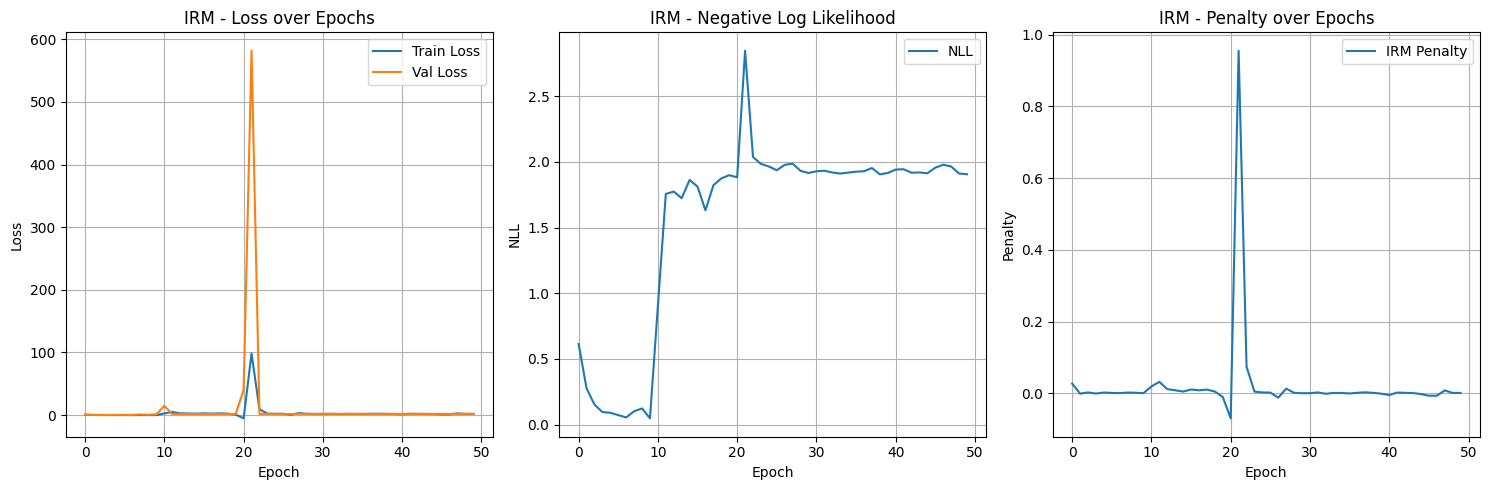

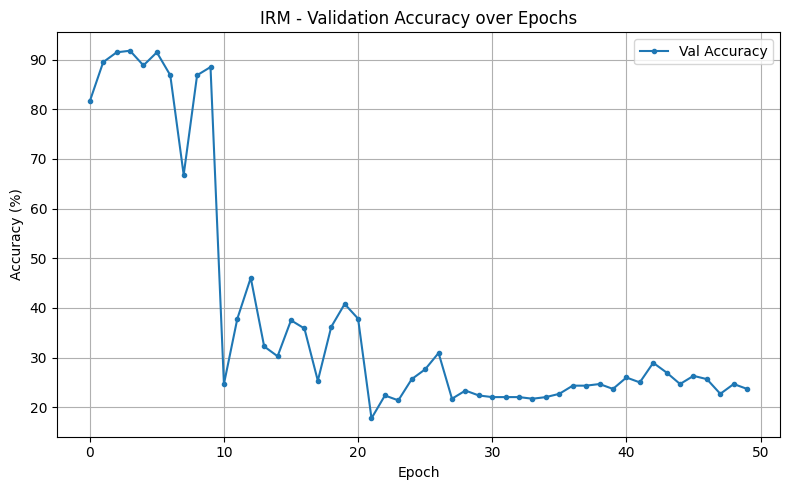

In [38]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(irm_train_losses, label='Train Loss')
plt.plot(irm_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IRM - Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(irm_train_nlls, label='NLL')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.title('IRM - Negative Log Likelihood')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(irm_train_penalties, label='IRM Penalty')
plt.xlabel('Epoch')
plt.ylabel('Penalty')
plt.title('IRM - Penalty over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(irm_val_accuracies, label='Val Accuracy', marker='o', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('IRM - Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Group DRO

In [39]:
class GroupDRO(ERM):
    """
    Robust ERM minimizes the error at the worst minibatch
    Algorithm 1 from [https://arxiv.org/pdf/1911.08731.pdf]
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(GroupDRO, self).__init__(input_shape, num_classes, num_domains,
                                        hparams)
        self.register_buffer("q", torch.Tensor())

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"

        if not len(self.q):
            self.q = torch.ones(len(minibatches)).to(device)

        losses = torch.zeros(len(minibatches)).to(device)

        for m in range(len(minibatches)):
            x, y = minibatches[m]
            losses[m] = F.cross_entropy(self.predict(x), y)
            self.q[m] *= (self.hparams["groupdro_eta"] * losses[m].data).exp()

        self.q /= self.q.sum()

        loss = torch.dot(losses, self.q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

In [40]:

input_shape = (3, 224, 224)
num_classes = len(pacs_train.classes)
num_domains = len(TRAIN_DOMAINS)

groupdro_hparams = {
    'groupdro_eta': 1e-2
}

groupdro_model = GroupDRO(input_shape, num_classes, num_domains, groupdro_hparams)
groupdro_model = groupdro_model.to(DEVICE)
print(f"GroupDRO Model initialized with {num_domains} domains and {num_classes} classes")

GroupDRO Model initialized with 3 domains and 7 classes


In [41]:
# Training loop for Group DRO
EPOCHS = 50
max_validation_accuracy = 0.0
groupdro_train_losses = []
groupdro_val_accuracies = []
groupdro_val_losses = []

print("Training GroupDRO model...")
for epoch in range(1, EPOCHS + 1):
    groupdro_model.train()
    
    # Create iterators for each domain
    domain_iterators = {domain: iter(loader) for domain, loader in train_domain_loaders.items()}
    
    epoch_loss = 0.0
    num_batches = 0
    
    # Get the minimum number of batches across all domains
    min_batches = min(len(loader) for loader in train_domain_loaders.values())
    
    for batch_idx in range(min_batches):
        # Collect one minibatch from each domain
        minibatches = []
        for domain in TRAIN_DOMAINS:
            try:
                images, labels, _ = next(domain_iterators[domain])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                minibatches.append((images, labels))
            except StopIteration:
                # Re-initialize iterator if exhausted
                domain_iterators[domain] = iter(train_domain_loaders[domain])
                images, labels, _ = next(domain_iterators[domain])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                minibatches.append((images, labels))
        
        # Update the model
        step_results = groupdro_model.update(minibatches)
        
        epoch_loss += step_results['loss']
        num_batches += 1
    
    # Average metrics
    avg_loss = epoch_loss / num_batches
    groupdro_train_losses.append(avg_loss)
    
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {avg_loss:.4f}")
    
    # Validation
    groupdro_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = groupdro_model.predict(images)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()
            val_batches += 1
            
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / val_batches
    
    groupdro_val_accuracies.append(val_acc)
    groupdro_val_losses.append(avg_val_loss)
    
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': groupdro_model.state_dict(),
            'val_acc': val_acc,
            'hparams': groupdro_hparams
        }, os.path.join(MODEL_DIR, 'best_groupdro_model.pth'))

# Save last model
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': groupdro_model.state_dict(),
    'val_acc': val_acc,
    'hparams': groupdro_hparams
}, os.path.join(MODEL_DIR, 'groupdro_model.pth'))

print("\nTraining completed!")
print(f"Best validation accuracy: {max_validation_accuracy:.2f}%")

Training GroupDRO model...
Epoch 1/50
  Train Loss: 0.5417
  Val Loss: 0.4690, Val Acc: 87.17%
Epoch 2/50
  Train Loss: 0.2383
  Val Loss: 0.5682, Val Acc: 86.84%
Epoch 3/50
  Train Loss: 0.1578
  Val Loss: 1.7101, Val Acc: 85.20%
Epoch 4/50
  Train Loss: 0.1375
  Val Loss: 0.4022, Val Acc: 87.83%
Epoch 5/50
  Train Loss: 0.1069
  Val Loss: 0.3174, Val Acc: 90.46%
Epoch 6/50
  Train Loss: 0.1060
  Val Loss: 0.5643, Val Acc: 87.17%
Epoch 7/50
  Train Loss: 0.0812
  Val Loss: 0.2110, Val Acc: 94.74%
Epoch 8/50
  Train Loss: 0.0509
  Val Loss: 0.4087, Val Acc: 89.80%
Epoch 9/50
  Train Loss: 0.0598
  Val Loss: 0.4606, Val Acc: 89.47%
Epoch 10/50
  Train Loss: 0.0595
  Val Loss: 0.3923, Val Acc: 89.80%
Epoch 11/50
  Train Loss: 0.0456
  Val Loss: 0.4088, Val Acc: 90.46%
Epoch 12/50
  Train Loss: 0.0448
  Val Loss: 0.3679, Val Acc: 89.80%
Epoch 13/50
  Train Loss: 0.0284
  Val Loss: 0.3681, Val Acc: 89.14%
Epoch 14/50
  Train Loss: 0.0351
  Val Loss: 0.2803, Val Acc: 93.09%
Epoch 15/50
  Tr

## Evaluate Group DRO Model - Best Checkpoint 

In [42]:
## Evaluate GroupDRO Model - Best Checkpoint
checkpoint = torch.load(os.path.join(MODEL_DIR, 'best_groupdro_model.pth'))
groupdro_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val_acc: {checkpoint['val_acc']:.2f}%")

Loaded best model from epoch 7 with val_acc: 94.74%


In [43]:
def compute_accuracy_groupdro(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.predict(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

### Target Domain Evaluation (Best)

In [44]:
### Target Domain Evaluation (Best)
sketch_accuracy_groupdro = compute_accuracy_groupdro(groupdro_model, pacs_test_loader)
print(f"GroupDRO Model Accuracy on PACS Sketch Domain (Target): {sketch_accuracy_groupdro:.2f}%")

GroupDRO Model Accuracy on PACS Sketch Domain (Target): 61.59%


### Source Domain Evaluation (Best)

In [45]:
### Source Domain Evaluation (Best)
source_accuracy_groupdro = compute_accuracy_groupdro(groupdro_model, pacs_source_loader)
print(f"GroupDRO Model Accuracy on PACS Source Domains (Overall): {source_accuracy_groupdro:.2f}%")

source_photo_accuracy_groupdro = compute_accuracy_groupdro(groupdro_model, pacs_photo_loader)
print(f"GroupDRO Model Accuracy on PACS Photo Domain: {source_photo_accuracy_groupdro:.2f}%")

source_art_painting_accuracy_groupdro = compute_accuracy_groupdro(groupdro_model, pacs_art_painting_loader)
print(f"GroupDRO Model Accuracy on PACS Art Painting Domain: {source_art_painting_accuracy_groupdro:.2f}%")

source_cartoon_accuracy_groupdro = compute_accuracy_groupdro(groupdro_model, pacs_cartoon_loader)
print(f"GroupDRO Model Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_groupdro:.2f}%")

domain_accuracies = [source_photo_accuracy_groupdro, source_art_painting_accuracy_groupdro, source_cartoon_accuracy_groupdro]
worst_group_acc_groupdro = min(domain_accuracies)
avg_source_acc_groupdro = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_groupdro:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_groupdro:.2f}%")

GroupDRO Model Accuracy on PACS Source Domains (Overall): 98.04%
GroupDRO Model Accuracy on PACS Photo Domain: 98.74%
GroupDRO Model Accuracy on PACS Art Painting Domain: 97.12%
GroupDRO Model Accuracy on PACS Cartoon Domain: 98.34%

Worst-group accuracy (source domains): 97.12%
Average accuracy (source domains): 98.07%


## Evaluate Group DRO Model - Last Checkpoint 

In [46]:
## Evaluate GroupDRO Model - Last Checkpoint
checkpoint = torch.load(os.path.join(MODEL_DIR, 'groupdro_model.pth'))
groupdro_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded last model from epoch {checkpoint['epoch']} with val_acc: {checkpoint['val_acc']:.2f}%")

Loaded last model from epoch 50 with val_acc: 89.14%


### Target Domain Evaluation (Last)

In [47]:
### Target Domain Evaluation (Last)
sketch_accuracy_groupdro_last = compute_accuracy_groupdro(groupdro_model, pacs_test_loader)
print(f"GroupDRO Model Accuracy on PACS Sketch Domain (Target): {sketch_accuracy_groupdro_last:.2f}%")

GroupDRO Model Accuracy on PACS Sketch Domain (Target): 66.05%


### Source Domain Evaluation (Last)

In [48]:
### Source Domain Evaluation (Last)
source_accuracy_groupdro_last = compute_accuracy_groupdro(groupdro_model, pacs_source_loader)
print(f"GroupDRO Model Accuracy on PACS Source Domains (Overall): {source_accuracy_groupdro_last:.2f}%")

source_photo_accuracy_groupdro_last = compute_accuracy_groupdro(groupdro_model, pacs_photo_loader)
print(f"GroupDRO Model Accuracy on PACS Photo Domain: {source_photo_accuracy_groupdro_last:.2f}%")

source_art_painting_accuracy_groupdro_last = compute_accuracy_groupdro(groupdro_model, pacs_art_painting_loader)
print(f"GroupDRO Model Accuracy on PACS Art Painting Domain: {source_art_painting_accuracy_groupdro_last:.2f}%")

source_cartoon_accuracy_groupdro_last = compute_accuracy_groupdro(groupdro_model, pacs_cartoon_loader)
print(f"GroupDRO Model Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_groupdro_last:.2f}%")

domain_accuracies_last = [source_photo_accuracy_groupdro_last, source_art_painting_accuracy_groupdro_last, source_cartoon_accuracy_groupdro_last]
worst_group_acc_groupdro_last = min(domain_accuracies_last)
avg_source_acc_groupdro_last = np.mean(domain_accuracies_last)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_groupdro_last:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_groupdro_last:.2f}%")

GroupDRO Model Accuracy on PACS Source Domains (Overall): 98.55%
GroupDRO Model Accuracy on PACS Photo Domain: 99.04%
GroupDRO Model Accuracy on PACS Art Painting Domain: 98.68%
GroupDRO Model Accuracy on PACS Cartoon Domain: 98.08%

Worst-group accuracy (source domains): 98.08%
Average accuracy (source domains): 98.60%


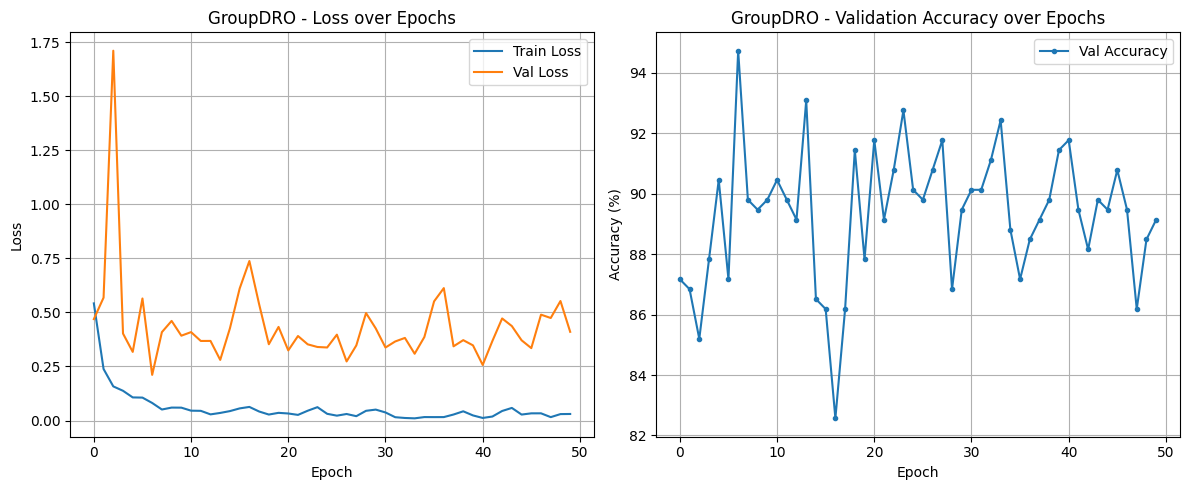

In [49]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(groupdro_train_losses, label='Train Loss')
plt.plot(groupdro_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GroupDRO - Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(groupdro_val_accuracies, label='Val Accuracy', marker='o', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('GroupDRO - Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4) SAM

In [ ]:
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in sam_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

# for m in erm_resnet_pacs.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.eval()


sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
sam_resnet_pacs_base_optimizer = optim.SGD
sam_resnet_pacs_optimizer = SAM(sam_resnet_pacs.parameters(), sam_resnet_pacs_base_optimizer, \
    rho=0.05, adaptive=False, lr=0.001, momentum=0.9, weight_decay=0.0005)
# no scheduler for SAM
EPOCHS = 50

In [ ]:
max_validation_accuracy = 0.0
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    sam_resnet_pacs.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels, _ in pacs_train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        enable_running_stats(sam_resnet_pacs)
        outputs = sam_resnet_pacs(images)
        loss = sam_resnet_pacs_criterion(outputs, labels)
        loss.backward()
        sam_resnet_pacs_optimizer.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(sam_resnet_pacs)
        sam_resnet_pacs_criterion(sam_resnet_pacs(images), labels).backward()
        sam_resnet_pacs_optimizer.second_step(zero_grad=True)

        with torch.no_grad():
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(pacs_train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    sam_resnet_pacs.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = sam_resnet_pacs(images)
            loss = sam_resnet_pacs_criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save(sam_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'best_sam_resnet.pth'))
    avg_val_loss = val_running_loss / len(pacs_val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
torch.save(sam_resnet_pacs.state_dict(), 'sam_resnet.pth')

Epoch 1
	Training Loss: 1.1073, Train Acc: 69.05%
	Validation Loss: 0.4865, Validation Acc: 91.12%
Epoch 2
	Training Loss: 0.3187, Train Acc: 92.62%
	Validation Loss: 0.2571, Validation Acc: 93.09%
Epoch 3
	Training Loss: 0.1768, Train Acc: 95.80%
	Validation Loss: 0.1965, Validation Acc: 93.75%
Epoch 4
	Training Loss: 0.1221, Train Acc: 97.55%
	Validation Loss: 0.1577, Validation Acc: 94.08%
Epoch 5
	Training Loss: 0.0881, Train Acc: 98.12%
	Validation Loss: 0.1476, Validation Acc: 95.07%
Epoch 6
	Training Loss: 0.0686, Train Acc: 98.71%
	Validation Loss: 0.1170, Validation Acc: 96.05%
Epoch 7
	Training Loss: 0.0536, Train Acc: 98.98%
	Validation Loss: 0.0987, Validation Acc: 97.04%
Epoch 8
	Training Loss: 0.0402, Train Acc: 99.41%
	Validation Loss: 0.0926, Validation Acc: 96.05%
Epoch 9
	Training Loss: 0.0356, Train Acc: 99.37%
	Validation Loss: 0.0841, Validation Acc: 96.71%
Epoch 10
	Training Loss: 0.0276, Train Acc: 99.72%
	Validation Loss: 0.0865, Validation Acc: 97.37%
Epoch 11


## Evaluate SAM Model - Best Checkpoint 

In [ ]:
sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_sam_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Best)

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 72.10%


### Source Domain Evaluation (Best)

In [ ]:
source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.95%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.85%
ResNet-50 Accuracy on PACS Cartoon Domain: 100.00%


## Evaluate SAM Model - Last Checkpoint 

In [ ]:
sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'sam_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Last)

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 73.07%


### Source Domain Evaluation (Last)

In [ ]:
source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.92%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.80%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.96%


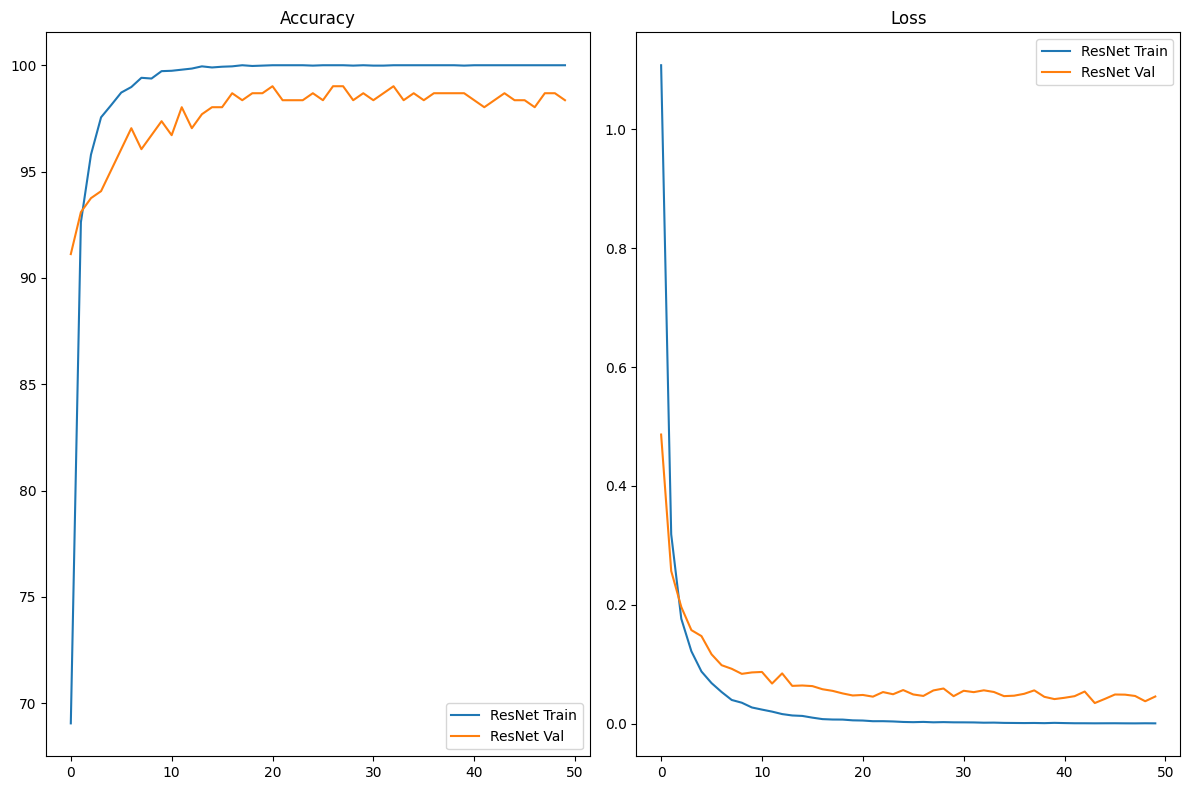

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='ResNet Train')
plt.plot(val_accuracies, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label='ResNet Train')
plt.plot(val_losses, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Extra

In [ ]:
# def measure_sharpness(model, dataloader, epsilon=0.01, num_directions=10):
#     """
#     Measure sharpness by perturbing model parameters and checking loss increase.
    
#     Args:
#         model: The trained model
#         dataloader: DataLoader to compute loss on
#         epsilon: Perturbation magnitude
#         num_directions: Number of random directions to sample
    
#     Returns:
#         Dictionary with sharpness metrics
#     """
#     model.eval()
#     device = next(model.parameters()).device
    
#     # Get original loss
#     original_loss = 0.0
#     num_batches = 0
#     with torch.no_grad():
#         for images, labels, _ in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             original_loss += F.cross_entropy(outputs, labels).item()
#             num_batches += 1
#     original_loss /= num_batches
    
#     # Store original parameters
#     original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
#     # Sample random directions and measure loss increase
#     loss_increases = []
    
#     for _ in range(num_directions):
#         # Generate random direction
#         with torch.no_grad():
#             for p in model.parameters():
#                 if p.requires_grad:
#                     # Random perturbation with same shape as parameter
#                     perturbation = torch.randn_like(p) * epsilon
#                     p.add_(perturbation)
        
#         # Compute perturbed loss
#         perturbed_loss = 0.0
#         num_batches = 0
#         with torch.no_grad():
#             for images, labels, _ in dataloader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 perturbed_loss += F.cross_entropy(outputs, labels).item()
#                 num_batches += 1
#         perturbed_loss /= num_batches
        
#         loss_increases.append(perturbed_loss - original_loss)
        
#         # Restore original parameters for next iteration
#         with torch.no_grad():
#             for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#                 p.copy_(orig_p)
    
#     # Restore original parameters
#     with torch.no_grad():
#         for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#             p.copy_(orig_p)
    
#     return {
#         'original_loss': original_loss,
#         'mean_loss_increase': np.mean(loss_increases),
#         'max_loss_increase': np.max(loss_increases),
#         'std_loss_increase': np.std(loss_increases),
#         'sharpness': np.mean(loss_increases) / original_loss  # Normalized sharpness
#     }
    
# def measure_cross_domain_flatness(model, domain_loaders, epsilon=0.01, num_directions=10):
#     """
#     Measure cross-domain flatness: perturbations that hurt one domain should hurt all.
    
#     Returns correlation between loss increases across domains.
#     """
#     model.eval()
#     device = next(model.parameters()).device
    
#     # Get original losses for each domain
#     original_losses = {}
#     for domain_name, loader in domain_loaders.items():
#         loss = 0.0
#         num_batches = 0
#         with torch.no_grad():
#             for images, labels, _ in loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss += F.cross_entropy(outputs, labels).item()
#                 num_batches += 1
#         original_losses[domain_name] = loss / num_batches
    
#     # Store original parameters
#     original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
#     # Track loss increases per domain for each perturbation
#     domain_increases = {domain: [] for domain in domain_loaders.keys()}
    
#     for _ in range(num_directions):
#         # Apply same random perturbation
#         with torch.no_grad():
#             for p in model.parameters():
#                 if p.requires_grad:
#                     perturbation = torch.randn_like(p) * epsilon
#                     p.add_(perturbation)
        
#         # Measure loss increase for each domain
#         for domain_name, loader in domain_loaders.items():
#             perturbed_loss = 0.0
#             num_batches = 0
#             with torch.no_grad():
#                 for images, labels, _ in loader:
#                     images, labels = images.to(device), labels.to(device)
#                     outputs = model(images)
#                     perturbed_loss += F.cross_entropy(outputs, labels).item()
#                     num_batches += 1
#             perturbed_loss /= num_batches
            
#             domain_increases[domain_name].append(perturbed_loss - original_losses[domain_name])
        
#         # Restore parameters
#         with torch.no_grad():
#             for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#                 p.copy_(orig_p)
    
#     # Restore original parameters
#     with torch.no_grad():
#         for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#             p.copy_(orig_p)
    
#     # Compute correlation matrix between domain loss increases
#     domain_names = list(domain_loaders.keys())
#     increases_array = np.array([domain_increases[d] for d in domain_names])
#     correlation_matrix = np.corrcoef(increases_array)
    
#     return {
#         'domain_increases': domain_increases,
#         'correlation_matrix': correlation_matrix,
#         'mean_correlation': np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]),
#         'original_losses': original_losses
#     }
    
# def compute_loss_landscape_2d(model, dataloader, direction1, direction2, 
#                                alpha_range=(-1, 1), beta_range=(-1, 1), 
#                                steps=20):
#     """
#     Compute 2D loss landscape by moving in two random directions.
    
#     Args:
#         model: The model to analyze
#         dataloader: Data to compute loss on
#         direction1, direction2: List of parameter perturbations (same structure as model params)
#         alpha_range, beta_range: Range for each direction
#         steps: Number of points to sample in each direction
    
#     Returns:
#         alphas, betas, losses (meshgrid for plotting)
#     """
#     model.eval()
#     device = next(model.parameters()).device
    
#     # Store original parameters
#     original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
#     # Create grid
#     alphas = np.linspace(alpha_range[0], alpha_range[1], steps)
#     betas = np.linspace(beta_range[0], beta_range[1], steps)
#     losses = np.zeros((len(betas), len(alphas)))
    
#     # Compute loss at each grid point
#     for i, beta in enumerate(betas):
#         for j, alpha in enumerate(alphas):
#             # Perturb parameters: θ = θ_0 + α*d1 + β*d2
#             with torch.no_grad():
#                 for p, orig_p, d1, d2 in zip([p for p in model.parameters() if p.requires_grad], 
#                                               original_params, direction1, direction2):
#                     p.copy_(orig_p + alpha * d1 + beta * d2)
            
#             # Compute loss
#             loss = 0.0
#             num_batches = 0
#             with torch.no_grad():
#                 for images, labels, _ in dataloader:
#                     images, labels = images.to(device), labels.to(device)
#                     outputs = model(images)
#                     loss += F.cross_entropy(outputs, labels).item()
#                     num_batches += 1
#                     if num_batches >= 10:  # Limit batches for speed
#                         break
#             losses[i, j] = loss / num_batches
    
#     # Restore original parameters
#     with torch.no_grad():
#         for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
#             p.copy_(orig_p)
    
#     return alphas, betas, losses

# def generate_random_directions(model, num_directions=2):
#     """Generate random directions for loss landscape visualization."""
#     directions = []
#     for _ in range(num_directions):
#         direction = []
#         for p in model.parameters():
#             if p.requires_grad:
#                 # Random direction normalized to unit norm
#                 d = torch.randn_like(p)
#                 d = d / torch.norm(d)
#                 direction.append(d)
#         directions.append(direction)
#     return directions

# def visualize_loss_landscape(model, dataloader, model_name="Model", 
#                              alpha_range=(-0.5, 0.5), beta_range=(-0.5, 0.5), 
#                              steps=20):
#     """
#     Create 2D visualization of loss landscape.
#     """
#     print(f"Computing loss landscape for {model_name}...")
    
#     # Generate two random directions
#     directions = generate_random_directions(model, num_directions=2)
#     direction1, direction2 = directions[0], directions[1]
    
#     # Compute landscape
#     alphas, betas, losses = compute_loss_landscape_2d(
#         model, dataloader, direction1, direction2,
#         alpha_range, beta_range, steps
#     )
    
#     # Plot
#     fig = plt.figure(figsize=(14, 5))
    
#     # 3D surface plot
#     ax1 = fig.add_subplot(121, projection='3d')
#     X, Y = np.meshgrid(alphas, betas)
#     surf = ax1.plot_surface(X, Y, losses, cmap='viridis', alpha=0.8)
#     ax1.set_xlabel('Direction 1 (α)')
#     ax1.set_ylabel('Direction 2 (β)')
#     ax1.set_zlabel('Loss')
#     ax1.set_title(f'{model_name} - Loss Surface')
#     fig.colorbar(surf, ax=ax1, shrink=0.5)
    
#     # Contour plot
#     ax2 = fig.add_subplot(122)
#     contour = ax2.contourf(X, Y, losses, levels=20, cmap='viridis')
#     ax2.contour(X, Y, losses, levels=10, colors='black', alpha=0.3, linewidths=0.5)
#     ax2.plot(0, 0, 'r*', markersize=15, label='Current solution')
#     ax2.set_xlabel('Direction 1 (α)')
#     ax2.set_ylabel('Direction 2 (β)')
#     ax2.set_title(f'{model_name} - Loss Contours')
#     ax2.legend()
#     fig.colorbar(contour, ax=ax2)
    
#     plt.tight_layout()
#     plt.show()
    
#     return alphas, betas, losses

# # Load best models
# print("Loading best models for flatness analysis...")

# # ERM
# erm_resnet_pacs.load_state_dict(torch.load('best_erm_resnet.pth'))
# # SAM
# sam_resnet_pacs.load_state_dict(torch.load('best_sam_resnet.pth'))

# print("\n" + "="*80)
# print("FLATNESS ANALYSIS")
# print("="*80)

# # 1. Measure sharpness on validation set
# print("\n1. SINGLE-DOMAIN SHARPNESS (Validation Set)")
# print("-" * 80)

# erm_sharpness = measure_sharpness(erm_resnet_pacs, pacs_val_loader, epsilon=0.01, num_directions=20)
# sam_sharpness = measure_sharpness(sam_resnet_pacs, pacs_val_loader, epsilon=0.01, num_directions=20)

# print(f"\nERM Model:")
# print(f"  Original Loss: {erm_sharpness['original_loss']:.4f}")
# print(f"  Mean Loss Increase: {erm_sharpness['mean_loss_increase']:.4f}")
# print(f"  Max Loss Increase: {erm_sharpness['max_loss_increase']:.4f}")
# print(f"  Std Loss Increase: {erm_sharpness['std_loss_increase']:.4f}")
# print(f"  Normalized Sharpness: {erm_sharpness['sharpness']:.4f}")

# print(f"\nSAM Model:")
# print(f"  Original Loss: {sam_sharpness['original_loss']:.4f}")
# print(f"  Mean Loss Increase: {sam_sharpness['mean_loss_increase']:.4f}")
# print(f"  Max Loss Increase: {sam_sharpness['max_loss_increase']:.4f}")
# print(f"  Std Loss Increase: {sam_sharpness['std_loss_increase']:.4f}")
# print(f"  Normalized Sharpness: {sam_sharpness['sharpness']:.4f}")

# print(f"\n➤ SAM achieves {(erm_sharpness['sharpness'] / sam_sharpness['sharpness']):.2f}x flatter minimum!")

# # 2. Cross-domain flatness
# print("\n2. CROSS-DOMAIN FLATNESS")
# print("-" * 80)

# # Create domain loaders for measurement
# domain_loaders_dict = {
#     'photo': pacs_photo_loader,
#     'art_painting': pacs_art_painting_loader,
#     'cartoon': pacs_cartoon_loader
# }

# erm_cross_flatness = measure_cross_domain_flatness(
#     erm_resnet_pacs, domain_loaders_dict, epsilon=0.01, num_directions=20
# )
# sam_cross_flatness = measure_cross_domain_flatness(
#     sam_resnet_pacs, domain_loaders_dict, epsilon=0.01, num_directions=20
# )

# print(f"\nERM Model:")
# print(f"  Mean Cross-Domain Correlation: {erm_cross_flatness['mean_correlation']:.4f}")
# print(f"  Correlation Matrix:")
# print(erm_cross_flatness['correlation_matrix'])

# print(f"\nSAM Model:")
# print(f"  Mean Cross-Domain Correlation: {sam_cross_flatness['mean_correlation']:.4f}")
# print(f"  Correlation Matrix:")
# print(sam_cross_flatness['correlation_matrix'])

# # Visualize correlation matrices
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# im1 = axes[0].imshow(erm_cross_flatness['correlation_matrix'], cmap='coolwarm', vmin=-1, vmax=1)
# axes[0].set_title('ERM - Cross-Domain Loss Correlation')
# axes[0].set_xticks(range(3))
# axes[0].set_yticks(range(3))
# axes[0].set_xticklabels(['photo', 'art', 'cartoon'])
# axes[0].set_yticklabels(['photo', 'art', 'cartoon'])
# plt.colorbar(im1, ax=axes[0])

# im2 = axes[1].imshow(sam_cross_flatness['correlation_matrix'], cmap='coolwarm', vmin=-1, vmax=1)
# axes[1].set_title('SAM - Cross-Domain Loss Correlation')
# axes[1].set_xticks(range(3))
# axes[1].set_yticks(range(3))
# axes[1].set_xticklabels(['photo', 'art', 'cartoon'])
# axes[1].set_yticklabels(['photo', 'art', 'cartoon'])
# plt.colorbar(im2, ax=axes[1])

# plt.tight_layout()
# plt.show()

# print(f"\n➤ Higher correlation = better cross-domain flatness (perturbations hurt all domains equally)")

# # 3. Visualize loss landscapes
# print("\n3. LOSS LANDSCAPE VISUALIZATION")
# print("-" * 80)

# # Use a subset of validation data for speed
# val_subset_size = 500
# val_subset_indices = torch.randperm(len(pacs_val_split))[:val_subset_size]
# val_subset = torch.utils.data.Subset(pacs_val_split, val_subset_indices)
# val_subset_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

# print("\nVisualizing ERM loss landscape...")
# erm_alphas, erm_betas, erm_losses = visualize_loss_landscape(
#     erm_resnet_pacs, val_subset_loader, model_name="ERM",
#     alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
# )

# print("\nVisualizing SAM loss landscape...")
# sam_alphas, sam_betas, sam_losses = visualize_loss_landscape(
#     sam_resnet_pacs, val_subset_loader, model_name="SAM",
#     alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
# )

# # Compare flatness: compute average gradient magnitude around minimum
# print("\n4. QUANTITATIVE COMPARISON")
# print("-" * 80)

# def compute_local_curvature(losses):
#     """Compute average absolute gradient magnitude around center."""
#     center_i, center_j = losses.shape[0] // 2, losses.shape[1] // 2
#     gradients = []
#     for di in [-1, 0, 1]:
#         for dj in [-1, 0, 1]:
#             if di == 0 and dj == 0:
#                 continue
#             i, j = center_i + di, center_j + dj
#             if 0 <= i < losses.shape[0] and 0 <= j < losses.shape[1]:
#                 gradients.append(abs(losses[i, j] - losses[center_i, center_j]))
#     return np.mean(gradients)

# erm_curvature = compute_local_curvature(erm_losses)
# sam_curvature = compute_local_curvature(sam_losses)

# print(f"ERM Local Curvature: {erm_curvature:.4f}")
# print(f"SAM Local Curvature: {sam_curvature:.4f}")
# print(f"➤ SAM has {(erm_curvature / sam_curvature):.2f}x flatter local region!")